In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **Use various clustering techniques**
## **Dataset - Yelp Restaurants**

About - From the Business Objects, I tried to find food related areas in Portland city. These are characterized by closeness and similarity of restaurants. Used the "longitude" and "latitude" to cluster closeness. Used "categories" to cluster for similarity.

Found clusters using the following techniques
* **K-Means from scratch**
* **Hierarchical**
* **Gaussian Mixture Model**
* **DBSCAN**

In [ ]:
import json
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sklearn.datasets as sk_data
import sklearn.metrics as metrics
from sklearn.mixture import GaussianMixture as GMM
import seaborn as sns
from sklearn.manifold import MDS
from matplotlib import pyplot
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import SnowballStemmer
from collections import OrderedDict
from scipy.cluster.hierarchy import fcluster,dendrogram, linkage, cophenet
from sklearn import mixture
from scipy.spatial.distance import pdist
%matplotlib inline

# Data Preparation 

#1 dropping records those don’t have restaurants related information  

def extract(obj):
    ob = json.loads(obj)
    for key, value in list(ob.items()):
        if value and (key == 'categories'):
            if ('Restaurants' not in value):
                del ob[key]
            else:
                ob[key] = value #','.join(value)  
    return ob

#2 stemming process

def process(data):
    return " ".join([SnowballStemmer('english').stem(word) for word in data])

def convert(j):
    for i in t15:
        if(i == j):
            return(t15.index(i)+1)

def appending(j):
    if j in t15:
        c.append(j)

#3 Generate Elbow chart to calculating k(identify number of cluster)        
def evaluate_clusters(final_df,max_clusters):
    error = np.zeros(max_clusters+1)
    error[0] = 0;
    for k in range(1,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit_predict(final_df)
        error[k] = kmeans.inertia_
    plt.figure(1)
    plt.plot(range(1,len(error)),error[1:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Error')
        
df = pd.DataFrame([extract(obj)for obj in open('/content/gdrive/MyDrive/datasets/yelp_academic_dataset_business.json')])

#4 Creating dataframe having 4 cols 'latitude', 'longitude', 'city', 'categories'
final_df = df[['latitude','longitude','city','categories']]

#5 Filter records for portland city
final_df = final_df.loc[final_df['city'] == 'Portland']

final_df = final_df[['latitude','longitude','categories']]

#6 Dropping null/none records
final_df = final_df.dropna(subset=['categories'])
final_df[['latitude','longitude']] = (final_df[['latitude','longitude']].sub(final_df[['latitude','longitude']].mean())).divide(final_df[['latitude','longitude']].std())

final_df.head()

,latitude,longitude,categories
1,2.050340,1.024026,"Salad, Soup, Sandwiches, Delis, Restaurants, C..."
36,0.149673,2.013940,"Nightlife, Sandwiches, Seafood, Restaurants"
50,-0.094558,-0.382013,"Vegetarian, Vegan, Sandwiches, Soup, American ..."
93,-0.161807,0.952418,"Food Stands, Restaurants, Sandwiches"
94,0.046193,-0.731567,"Restaurants, Food, Sandwiches, Breakfast & Bru..."


I parsed the data from the json file to a pandas dataframe. The final dataframe used for clustering has a total of 17 columns. Two of which are latitude and longitude and the remaining 15 are the columns of top15 categories of Restaurants in Portland city. If a category is present for a restaurant then its value for that column is 1.0 or else 0.I performed feature scaling on latitude and longitude by subtracting the mean of the entire column from each value and then dividing by the standard deviation (Also known as Z-score), thus scaling down the location to the range of categories.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

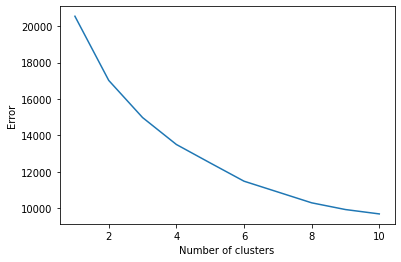

In [ ]:
top15_df = final_df.copy()
cat_list = final_df['categories'].tolist()
x = []
for i in cat_list:
     x += [i.split(',')]


count={}
for i in x:
    for j in i:
        if j not in count:
            count[j]=1
        else:
            count[j] = count[j] +1
top15_names=[]
od = OrderedDict(sorted(count.items(), key=lambda kv:kv[1], reverse=True))    
t15 = list(od)[1:16] # Eliminating Restaurants
top15_names = t15
t15_counts = list(od.values())[1:16]
trimmed_list = []
unwanted = []
c =[]

for i in final_df['categories']:
    row = i.split(',')
    c += [[convert(j) for j in row if j in t15]]
    #c += [[ j for j in row if j in t15]]
    
    #trimmed_list.append(row)
#print(c)
top15_df['categories'] = c
top15_df = top15_df.reset_index(drop = True)
a = np.zeros(shape=(len(top15_df['categories']),15))
i=0
for j in c:
    for k in j:
        a[i,(k-1)] = 1
    i+=1
t15= pd.DataFrame.from_records(a)
t15[['latitude','longitude']] = top15_df[['latitude','longitude']]

# Plot Elbow curve
evaluate_clusters(t15,10) #evaluates error versus number of clusters


## **Implementing K-Means from scratch**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# using the make_blobs dataset
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=100, centers=5, random_state=101)
# setting the number of training examples
m=X.shape[0]
n=X.shape[1] 
n_iter=50

In [ ]:
# computing the initial centroids randomly
K=5
import random

# creating an empty centroid array
centroids=np.array([]).reshape(n,0) 

# creating 5 random centroids
for k in range(K):
    centroids=np.c_[centroids,X[random.randint(0,m-1)]]

In [ ]:
output={}
# creating an empty array
euclid=np.array([]).reshape(m,0)

# finding distance between for each centroid
for k in range(K):
       dist=np.sum((X-centroids[:,k])**2,axis=1)
       euclid=np.c_[euclid,dist]

# storing the minimum value we have computed
minimum=np.argmin(euclid,axis=1)+1

In [ ]:
# computing the mean of separated clusters
cent={}
for k in range(K):
    cent[k+1]=np.array([]).reshape(2,0)

# assigning of clusters to points
for k in range(m):
    cent[minimum[k]]=np.c_[cent[minimum[k]],X[k]]
for k in range(K):
    cent[k+1]=cent[k+1].T

# computing mean and updating it
for k in range(K):
     centroids[:,k]=np.mean(cent[k+1],axis=0)

In [ ]:
# repeating the above steps again and again
for i in range(n_iter):
      euclid=np.array([]).reshape(m,0)
      for k in range(K):
          dist=np.sum((X-centroids[:,k])**2,axis=1)
          euclid=np.c_[euclid,dist]
      C=np.argmin(euclid,axis=1)+1
      cent={}
      for k in range(K):
           cent[k+1]=np.array([]).reshape(2,0)
      for k in range(m):
           cent[C[k]]=np.c_[cent[C[k]],X[k]]
      for k in range(K):
           cent[k+1]=cent[k+1].T
      for k in range(K):
           centroids[:,k]=np.mean(cent[k+1],axis=0)
      final=cent

Text(0.5, 1.0, 'Original Dataset')

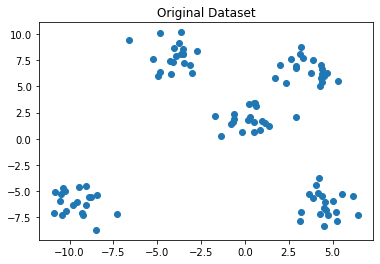

In [ ]:
plt.scatter(X[:,0],X[:,1])
plt.rcParams.update({'figure.figsize':(10,7.5), 'figure.dpi':100})
plt.title('Original Dataset')

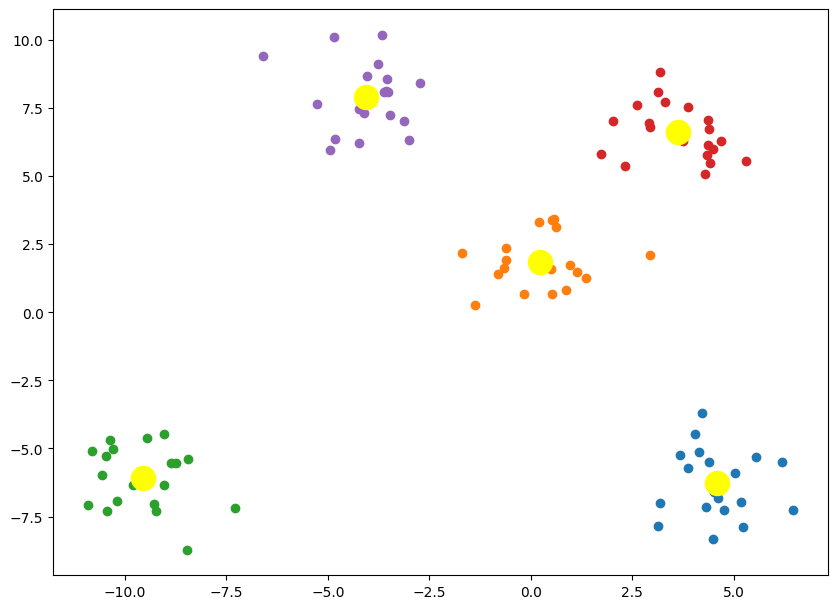

In [ ]:
for k in range(K):
    plt.scatter(final[k+1][:,0],final[k+1][:,1])
plt.scatter(centroids[0,:],centroids[1,:],s=300,c='yellow')
plt.rcParams.update({'figure.figsize':(10,7.5), 'figure.dpi':100})
plt.show()

## **Gaussian Mixture Model Clustering**




/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


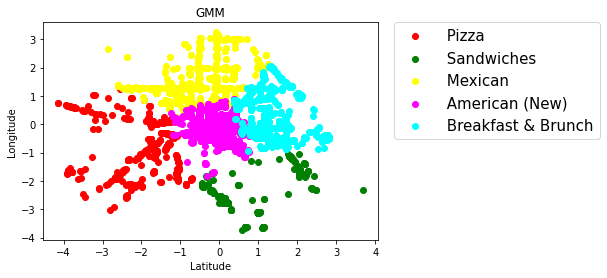

In [ ]:
#GMM

all_labels_gm=[]
gmm = GMM(n_components=5, covariance_type='spherical')
gmm.fit(t15)
gaussian = gmm.predict(t15)
mean = gmm.means_

g_0 = np.where(gaussian==0)
x= labels(g_0)
all_labels_gm.append(cluster_label(x, t15_counts))

g_1 = np.where(gaussian==1)
x= labels(g_1)
all_labels_gm.append(cluster_label(x, t15_counts))

g_2 = np.where(gaussian==2)
x= labels(g_2)
all_labels_gm.append(cluster_label(x, t15_counts))

g_3 = np.where(gaussian==3)
x= labels(g_3)
all_labels_gm.append(cluster_label(x, t15_counts))

g_4 = np.where(gaussian==4)
x= labels(g_4)
all_labels_gm.append(cluster_label(x, t15_counts))

clusters_gmm = [g_0,g_1,g_2,g_3,g_4]
colors = ['red','green','yellow','magenta','cyan']
plt.figure(2)

x = 0
for i in clusters_gmm:
    for j in i:
        plt.scatter(t15['latitude'][j],t15['longitude'][j], color=colors[x])
    x=x+1

plt.title('GMM')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
legend = plt.legend([all_labels_gm[i] for i in range(len(all_labels_gm))],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=15)
#referenced Stack overflow for legend tag and annotate
plt.show()

## **Hierarchical Clustering**

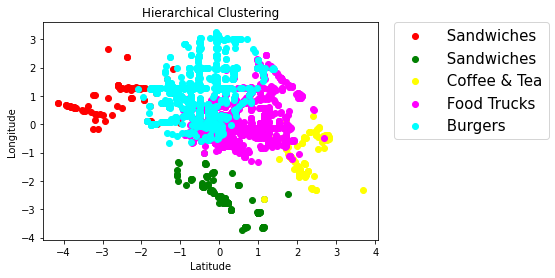

In [ ]:

#Hierarchical
hc = linkage(t15, method ='complete',metric = 'euclidean')
cluster = fcluster(hc,5,criterion='distance')
all_labels_hc=[]

h_1 = np.where(cluster==1)
h= labels(h_1)
all_labels_hc.append(cluster_label(h, t15_counts))

h_2 = np.where(cluster==2)
h= labels(h_2)
all_labels_hc.append(cluster_label(h, t15_counts))

h_3 = np.where(cluster==3)
h= labels(h_3)
all_labels_hc.append(cluster_label(h, t15_counts))

h_4 = np.where(cluster==4)
h= labels(h_4)
all_labels_hc.append(cluster_label(h, t15_counts))

h_5 = np.where(cluster==5)
h= labels(h_5)
all_labels_hc.append(cluster_label(h, t15_counts))

clusters_hc = [h_5,h_1,h_2,h_3,h_4]
colors = ['red','green','yellow','magenta','cyan']
plt.figure(1)

x = 0
for i in clusters_hc:
    for j in i:
        plt.scatter(t15['latitude'][j],t15['longitude'][j], color=colors[x])
    x=x+1

plt.title('Hierarchical Clustering')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
legend = plt.legend([all_labels_hc[i] for i in range(len(all_labels_hc))],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=15)
#referenced Stack overflow for legend tag and annotate
plt.show()


## **DBSCAN**

DBSCAN fits the model on the training dataset and predicts a cluster for each example in the dataset. A scatter plot is then created with points colored by their assigned cluster.

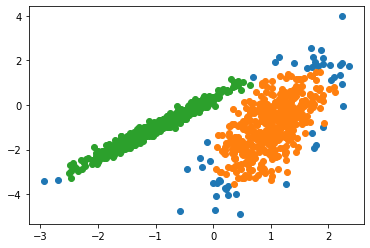

In [ ]:

# dbscan clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import DBSCAN
from matplotlib import pyplot
# define dataset
X, _ = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=4)
# define the model
model = DBSCAN(eps=0.30, min_samples=9)
# fit model and predict clusters
yhat = model.fit_predict(X)
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(yhat == cluster)
	# create scatter of these samples
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
pyplot.show()

**Comments**

I used complete link method for heirarchical clustering i.e finding the distance between the two points farthest from each other in order to combine clusters during the agglomerative clustering method. 

Performed GMM using co-variance as 'spherical' so that each component has its own single variance.


I calculated the ratio of each category present in the cluster with the total number of restaurants in Portland city of that category. And then selected the category having a maximum ratio as the label for that particular cluster. Thus, avoiding dominance by a particular category having large number of restaurants. Below is the interpretation of the results of the methods used.

**K-means**: K-means has more well-defined clusters because it does hard-clustering i.e. each point belongs to one and only one cluster. also, since the function used is kmeans, the initial points are calculated based on a probability function.

**Hierarchical**: Since it considers each point as a cluster on its own and then combines the points on the basis of distance between the points. It gives a result which varies quite a lot from the K-means method since it does not use any random points.

**Gaussian Mixture Model**: GMM uses soft-clustering and hence has overlapping clusters.It calculates the probability of a point belonging to each cluster and hence is more likely to give better clustering. It gives clustering similar to K-means but with some overlapping points.

**DBSCAN**: **DBSCAN** fits the model on the training dataset and predicts a cluster for each example in the dataset. A scatter plot is then created with points colored by their assigned cluster.
